Useful paths for the submission and for data

In [1]:
model_dir = 'agents/'
submission_dir = 'example_submission/'
problem_dir = 'utils/ingestion_program/'  
score_dir = 'utils/scoring_program/'
ref_data = 'utils/public_ref/'
ingestion_output = 'utils/logs/'

input_dir = 'public_data/'
output_dir = 'utils/output/'

In [2]:
from sys import path;
path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir); 

Useful external libraries for this notebook

In [3]:

import sys
import logging
import os
#%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
#import seaborn as sns; sns.set()
import warnings
import numpy as np
import pandas as pd
import evaluate
%matplotlib inline
import matplotlib.pyplot as plt
import json

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from utils.visualize_grid import plot_grid
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

# Connect Plotly in offline mode. 
init_notebook_mode(connected = True) 

During the challenge, a grid of 14 substations is given. 20 lines are connected through the nodes of the grids within substations.

explore others notebooks for better understanding of the power network behavior: 
 - Power_Grid_101_notebook.ipynb
 - visualize_14grid_with_customized_actions.ipynb

In our grid environment, we take the case where there are 11 loads and 5 prods. Furthermore, we will only consider chronics over the month of January, the only month for which contestants are tested.

In [5]:


loads_p_file = '_N_loads_p.csv' #active power chronics for loads
prods_p_file = '_N_prods_p.csv'  #active power chronics for productions
datetimes_file = '_N_datetimes.csv' #timesstamps of the chronics
maintenance_file = 'maintenance.csv' #maintenance operation chronics. No maintenance considered in the first challenge
hazards_file = 'hazards.csv'   #harzard chronics that disconnect lines. No hazards considered in the first challenge
imaps_file = '_N_imaps.csv' #thermal limits of the lines

i = 0 # chronics id
data_dir = input_dir+"datasets" #repository where to find all the chronics for a given difficulty level
path = data_dir+'/chronics/0000/'


We now load all data chronics to later visualize them. They will however be automaticall loaded in pypownet environment when run.

In [6]:
df_loads_p = {}
df_prods_p = {}
df_datetimes = {}
df_maintenance = {}
df_hazards = {} 

df_loads_p[str(i)] = pd.read_csv(path+loads_p_file, sep=';')
df_prods_p[str(i)] = pd.read_csv(path+prods_p_file, sep=';')
df_datetimes[str(i)] = pd.read_csv(path+datetimes_file, sep=';')
df_loads_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_prods_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_maintenance[str(i)] = pd.read_csv(path+maintenance_file, sep=';')
df_maintenance[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_hazards[str(i)] = pd.read_csv(path+hazards_file, sep=';')
df_hazards[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_imaps = pd.read_csv(path + imaps_file, sep=';')


## The Reward and the Score of an agent
At each step pypownet return a reward to the agent.

This reward is used to compute the Score for ranking participants in this current challenge.
the final Score is the sum of the score of each scenario. for a scenario there is two option :
 - Your agent got a game over, the Score for this scenario is 0
 - your agent got no game over, the Score of this scenario is the sum of the reward at each timestep of this scenario
 
### Computation of the reward
For each timestep pypownet returns a reward : the sum of the squared flow for each line <br>
<p>
    \[
        R= \sum_{l\in lines} \max\left(1- \frac{i_l}{i_{l_{max}}}^2,0\right)
    \]
</p>
With $i_l$ the flow on the line l and $i_{l_{max}}$ the maximum allowed flow on this line.<br>
The final score on one chronic is the sum of the rewards over the each timestep

for better understanding of the reward calulation please look at <code>public_data/reward_function.py</code> for training purposes you can modify this function. 


### Run an agent 

Once you have defined an agent, you can run it under an environment over scenarios.

NB: The runner from pypownet is perfectly fine but for the need of the leaderboard and its visualizations, the runner was augmented. The "augmented" version can be found in the starting kit. This is the runner that will run on the Codalab competition server. So before making a submission, make sure it runs with this runner as well. In the following you can choose one or the other, but to obtain a score as on the leaderboard, you need to run the "augmented" runner.

In [7]:

#from pypownet.runner import Runner
from runner import Runner #an override of pypownet.runner 
import os
import pypownet.environment

data_dir = 'public_data'  

def set_environment(game_level = "datasets", start_id=0):
    """
        Load the first chronic (scenario) in the directory public_data/datasets 
    """
    return pypownet.environment.RunEnv(parameters_folder=os.path.abspath(input_dir),
                                              game_level=game_level,
                                              chronic_looping_mode='natural', start_id=start_id,
                                              game_over_mode="soft")

def run_agent(environment, agent, number_iterations):
    # Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
    # by the scoring program
    log_path = os.path.abspath(os.path.join(ingestion_output, 'runner.log'))
    machinelog_filepath = os.path.abspath(os.path.join(ingestion_output,'machine_log.json'))# set to None 
    phase_runner = Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                          log_filepath=log_path, machinelog_filepath=machinelog_filepath)
    phase_runner.ch.setLevel(logging.ERROR)
    # Run the planned experiment of this phase with the submitted model
    score = phase_runner.loop(iterations=number_iterations)
    print("cumulative reward : {}".format(score))
    return score




In [19]:
from agents import brent_agents
agent = brent_agents.AgentQ(env_train, mode='train')
env_train = set_environment()
rewards = []
n_episodes = 2
n_iterations = 100
phase_runner = Runner(env_train, agent, verbose=True, vverbose=True)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(n_iterations, n_episodes)
np.save(os.path.join('saved_actions', 'qtable.np'), agent.qtable)

WARNING        Using custom reward signal CustomRewardSignal of file /Users/lunghino/enelx_l2rpn/public_data/reward_signal.py
WARNING        Using custom reward signal CustomRewardSignal of file /Users/lunghino/enelx_l2rpn/public_data/reward_signal.py
WARNING        Using custom reward signal CustomRewardSignal of file /Users/lunghino/enelx_l2rpn/public_data/reward_signal.py
INFO        Found 50 chronics of game level chronics; looping with mode natural starting with chronic 0000
INFO        Found 50 chronics of game level chronics; looping with mode natural starting with chronic 0000
INFO        Found 50 chronics of game level chronics; looping with mode natural starting with chronic 0000
INFO        Loading next chronic...
INFO        Loading next chronic...
INFO        Loading next chronic...


Storing actions at saved_actions/AgentZero.csv


INFO          loaded chronic 0000
INFO          loaded chronic 0000
INFO          loaded chronic 0000
DEBUG        observation: date: 2018 of 1 of 3 at 0h5m0s

 ====================================================================           ===================================================================
 |                               LOADS                              |           |                           PRODUCTIONS                           |
 ====================================================================           ===================================================================
 |                 | is  |         Current        | Previsions t+1  |           |                 | is  |         Current        | Previsions t+1 |
 | Sub. # | Node # | OFF |      P |     Q |     V |      P |      Q |           | Sub. # | Node # | OFF |      P |     Q |     V |      P |     V |
 |------- |------- |---- |------- |------ |------ |------- |------- |           |------- |------- |-

DEBUG        observation: date: 2018 of 1 of 3 at 0h5m0s

 ====================================================================           ===================================================================
 |                               LOADS                              |           |                           PRODUCTIONS                           |
 ====================================================================           ===================================================================
 |                 | is  |         Current        | Previsions t+1  |           |                 | is  |         Current        | Previsions t+1 |
 | Sub. # | Node # | OFF |      P |     Q |     V |      P |      Q |           | Sub. # | Node # | OFF |      P |     Q |     V |      P |     V |
 |------- |------- |---- |------- |------ |------ |------- |------- |           |------- |------- |---- |------- |------ |------ |------- |------ |
 |      2 |      0 |   0 |   19.2 | 13.40 |  1.01 |   

WARNING        Action has too much activations simultaneously: 12/1 activated substations, 11/1 switched lines and 23/2 total switched elements (substations and lines).
WARNING        Action has too much activations simultaneously: 12/1 activated substations, 11/1 switched lines and 23/2 total switched elements (substations and lines).
WARNING        Action has too much activations simultaneously: 12/1 activated substations, 11/1 switched lines and 23/2 total switched elements (substations and lines).
WARNING        Action has too much activations simultaneously: 12/1 activated substations, 11/1 switched lines and 23/2 total switched elements (substations and lines).


(392, 76)


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (392,) (76,) 

Now run it. 

You could load the agent from your own submission in submission.py. We explain after how to make a submission

In [80]:
import submission #existing example as submission.py
import brent_agents

NUMBER_ITERATIONS = 100 # The number of iterations can be changed

sys.path.append(model_dir)

if not os.path.exists(ingestion_output):
    os.makedirs(ingestion_output)
log_path = os.path.abspath(os.path.join(ingestion_output, 'runner.log'))
open(log_path, 'w').close()

env = set_environment()

submitted_controller = agent(env)
_ = run_agent(env, submitted_controller, NUMBER_ITERATIONS)


Storing actions at saved_actions/AgentZero.csv
cumulative reward : 1020.002468912675


In [81]:
# Please use the visualize_grid external script to display the 
# eletrical grid in the notebook.
obs = env._get_obs()
action = env.action_space.get_do_nothing_action()
grid_after_action = plot_grid(env, 
                              obs, 
                              action)

# Plot the grid
iplot(grid_after_action)

**WARNING**: the following cell to compute the leaderboard score will not run if you did not use the "augmented" runner previously.

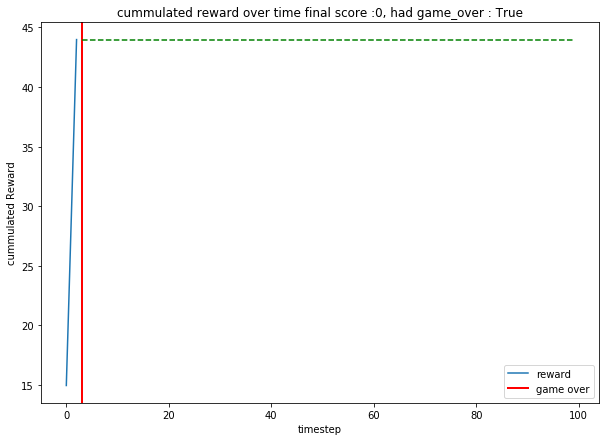

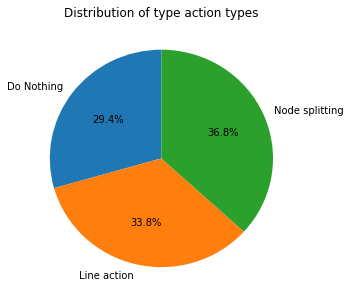

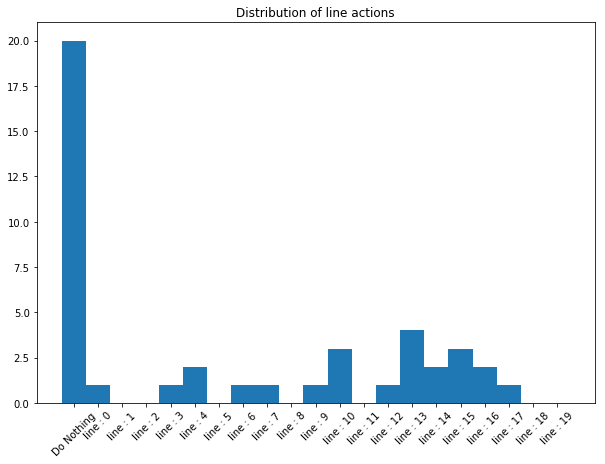

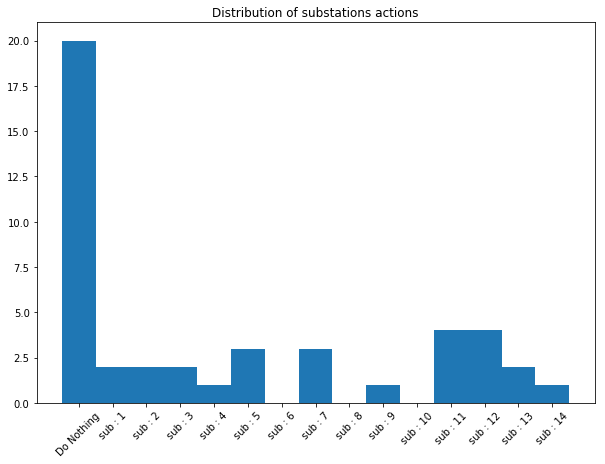

In [64]:
import evaluate
scoring_function = evaluate.extract_json
action_space = evaluate.get_action_space(os.path.join('utils',"ref"))
_ = scoring_function(os.path.join(ingestion_output, "machine_log.json"),action_space)

<div style="background:#FFFFAA">
    <b> Save the best agent </b> it should be a class Submission and save in "example_submission/submission.py".  Uncomment the line <i>%%writefile example_submission/submission.py to save the agent. </i>
</div>

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is create or modify the <code>Sumbission</code> class the file <code>submission.py</code>  in your `model_dir`, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. <br>

take note that on codalab, your local directory is <code>program/</code>. Then if you want to load the file <code>model.dump</code> run : <code>open("program/model.dump")</code> even if the file is in at the root of your submission dir.
</div>

In [68]:
#codalab command line used on the competition server. So it is best to test it as it is, rather than directly importing the related python method here and execute it. 
#you are supposed to run python 3 here. If "!python" command does not work, try "!python3" 
!python $problem_dir/ingestion.py $input_dir utils/res $problem_dir $model_dir

input dir: /Users/lunghino/enelx_l2rpn/public_data
output dir: /Users/lunghino/enelx_l2rpn/utils/res
program dir: /Users/lunghino/enelx_l2rpn/utils/ingestion_program
submission dir: /Users/lunghino/enelx_l2rpn/agents
input content ['full_chronic_names.json', 'reward_signal.py', 'datasets', '4_substations', '__pycache__', 'chronic_names.json']
output content ['log_files.json', 'runner.log', 'machine_log_1.json', 'machine_log_0.json', 'machine_log_3.json', 'machine_log_2.json']
program content ['ingestion.py', 'runner.py', '__pycache__', 'metadata']
submission content ['submission.py', 'brent_agents.py', '__pycache__']
Using custom reward signal CustomRewardSignal of file /Users/lunghino/enelx_l2rpn/public_data/reward_signal.py
Storing actions at saved_actions_AgentZero.csv
log file path /Users/lunghino/enelx_l2rpn/utils/res/runner.log
/Users/lunghino/enelx_l2rpn/.env/lib/python3.6/site-packages/pypower/fdpf.py:121: RuntimeWarning: overflow encountered in multiply
  mis = (V * conj(Ybus 

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [69]:
scoring_output_dir = 'results'

#you are supposed to run python3 here. If "!python" command does not work, try "!python3" 
!python $score_dir/evaluate.py utils $scoring_output_dir
print("watch : http:/view/"+ scoring_output_dir +"/scores.html")

utils
results
Using custom reward signal CustomRewardSignal of file /Users/lunghino/enelx_l2rpn/utils/ref/reward_signal.py
watch : http:/view/results/scores.html


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [67]:
# import datetime 
# import zipfile

# def zipdir(path, ziph):
#     # ziph is zipfile handle
#     for root, dirs, files in os.walk(path):
#         for file in files:
#             ziph.write(os.path.join(root, file))

# the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
# sample_code_submission = 'sample_code_submission_' + the_date + '.zip' 

# with zipfile.ZipFile(sample_code_submission, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipdir(submission_dir,zipf)
# print("Submit one of these files:\n" + sample_code_submission + "\n")